In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import completeness_score as com
from sklearn.cluster import DBSCAN
from bayes_opt import BayesianOptimization
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
table = pd.read_csv('hw_3_data.csv')

In [3]:
table.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,lbl
0,-0.105348,-0.765285,-0.105348,0.284124,0.430165,-0.496225,-1.630323,0.430165,-0.371408,-0.368030,0.0
1,0.078798,0.255358,0.078798,-0.464293,-0.340239,0.242046,0.539097,-0.340239,0.367130,-0.215124,0.0
2,0.138852,0.717872,0.138852,1.057301,0.130399,0.191773,1.446804,0.130399,-0.773516,1.043496,3.0
3,0.178963,0.820882,0.178963,1.750779,0.364299,-1.134097,1.618704,0.364299,-1.348497,1.469060,3.0
4,-0.928943,-0.583325,-0.928943,1.632376,1.674338,0.902454,-0.876673,1.674338,-0.345720,2.792298,2.0


In [4]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
f0     40000 non-null float64
f1     40000 non-null float64
f2     40000 non-null float64
f3     40000 non-null float64
f4     40000 non-null float64
f5     40000 non-null float64
f6     40000 non-null float64
f7     40000 non-null float64
f8     40000 non-null float64
f9     40000 non-null float64
lbl    40000 non-null float64
dtypes: float64(11)
memory usage: 3.4 MB


In [5]:
table.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,lbl
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-0.002991,0.003209,-0.002991,-0.009630,-0.002443,-0.006919,0.008981,-0.002443,0.012763,0.005384,1.499500
std,0.555049,0.669027,0.555049,1.473199,0.792873,1.000283,1.320918,0.792873,1.453225,1.324047,1.117668
min,-1.905599,-3.160811,-1.905599,-5.414462,-3.210632,-3.933070,-6.372736,-3.210632,-4.788817,-4.911375,0.000000
25%,-0.349748,-0.555245,-0.349748,-1.062237,-0.556013,-0.688123,-1.007493,-0.556013,-1.036148,-1.024616,1.000000
50%,-0.073417,0.037319,-0.073417,0.075740,0.081158,-0.009233,0.009509,0.081158,0.053543,0.036987,1.000000
75%,0.424013,0.531874,0.424013,1.045986,0.494282,0.671744,1.041563,0.494282,1.071657,1.014510,2.000000
max,2.782764,2.263375,2.782764,5.027650,2.735036,4.492202,4.276321,2.735036,5.395193,5.353837,3.000000


Дані не містять пропущених значень, середнє близько нуля

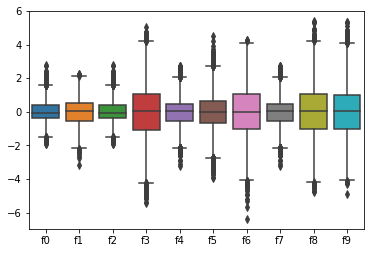

In [6]:
z = sns.boxplot(data=table.iloc[:,:-1])

З даного боксплоту помітна велика кількість викідів у кожній з фіч

lbl
0.0     9998
1.0    10009
2.0    10008
3.0     9985
Name: f0, dtype: int64


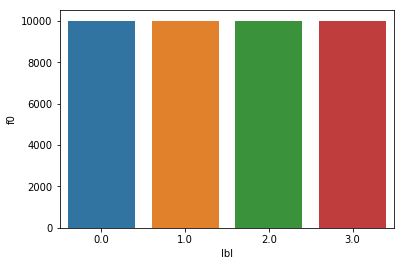

In [7]:
z = table.groupby(['lbl']).count()
sns.barplot(y=z['f0'], x=z.index, label=z['f0'])
print(z['f0'])

 Дані є збалансованими

In [8]:
corr = table.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,lbl
f0,1,0.57,1,0.21,-0.57,-0.0084,0.4,-0.57,-0.57,-0.64,-0.33
f1,0.57,1,0.57,0.059,-0.54,-0.0019,0.98,-0.54,-0.16,-0.043,0.25
f2,1,0.57,1,0.21,-0.57,-0.0084,0.4,-0.57,-0.57,-0.64,-0.33
f3,0.21,0.059,0.21,1,0.65,-0.0024,-0.033,0.65,-0.91,0.47,0.25
f4,-0.57,-0.54,-0.57,0.65,1,0.0036,-0.51,1,-0.35,0.78,0.34
f5,-0.0084,-0.0019,-0.0084,-0.0024,0.0036,1,-0.00013,0.0036,0.0058,0.0065,-0.0002
f6,0.4,0.98,0.4,-0.033,-0.51,-0.00013,1,-0.51,-0.0068,0.065,0.34
f7,-0.57,-0.54,-0.57,0.65,1,0.0036,-0.51,1,-0.35,0.78,0.34
f8,-0.57,-0.16,-0.57,-0.91,-0.35,0.0058,-0.0068,-0.35,1,-0.081,0.0028
f9,-0.64,-0.043,-0.64,0.47,0.78,0.0065,0.065,0.78,-0.081,1,0.67


З таблиці видно, що сильно між собою корелюють f3 i f8, f4 i f7, f1 i f6.У такому випадку доцільно залишати лише одну з пари корелюючих фіч. Спробуємо видалити f8, f7, f6

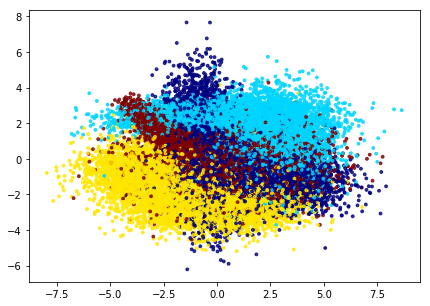

In [9]:
pca = PCA(n_components = 2)
table_2 = pca.fit_transform(table.iloc[:,:-1])
fig, ax = plt.subplots(1,1, figsize=(7,5))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
scat = ax.scatter(table_2.T[0],table_2.T[1],c=table.iloc[:,-1],cmap=cmap, alpha=0.8, s=8)
plt.show()

# Classification

Видалимо аутлайерів по правилу півтора міжквантильного розмаху. Видалимо корелюючі стовпці.

In [10]:
def remove_outlier(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    data = data.loc[(data[col_name] > fence_low) & (data[col_name] < fence_high)]
    return data

In [11]:
for i in table.columns:
    table = remove_outlier(table, i)

In [19]:
data = table.iloc[:, :-1]
target = table.iloc[:, -1]

In [13]:
data.drop(columns=['f6', 'f7', 'f8'], inplace=True)

Перевіримо збалансованість даних після видалення аутлайерів:

lbl
0.0    9732
1.0    9781
2.0    9754
3.0    9859
Name: f0, dtype: int64


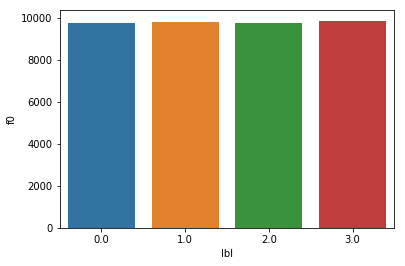

In [14]:
z = table.groupby(['lbl']).count()
sns.barplot(y=z['f0'], x=z.index, label=z['f0'])
print(z['f0'])

Визначимо наступні моделі та проведемо крос-валідацію:

In [72]:
models = [GradientBoostingClassifier(),
          SVC()
         ]

In [88]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=42)
acc_score = []
for model in models:
    for train, test in folds.split(x_train):
        metr = []
        mod = model.fit(x_train.iloc[train], y_train.iloc[train])
        result = mod.predict(x_train.iloc[test])
        metr.append(acc(y_pred=result, y_true=y_train.iloc[test]))
    acc_score.append(np.round(sum(metr)/len(metr), 4))
    print(f'Model: {model.__class__.__name__}:\n\t Accuracy:{sum(metr)/len(metr):.4f}')

Model: GradientBoostingClassifier:
	 Accuracy:0.8839
Model: SVC:
	 Accuracy:0.8676


За допомогою пошуку по сітці проведемо turning параметрів:

In [96]:
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=42)
parameters_gbc = {'n_estimators' : [100, 150, 250], 'max_depth' : [3, 5, 10]}
parameters_svm = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'C' : [1, 0.1, 2, 4]}
gbc = GradientBoostingClassifier()
svm = SVC()
grid_search_gbc = GridSearchCV(gbc, parameters_gbc, cv = 2)
grid_search_gbc.fit(x_train, y_train)
print(grid_search_gbc.best_params_)
print(f'GradientBoostingClassifier best for validation: {str(grid_search_gbc.best_score_)}')
grid_search_svm = GridSearchCV(svm, parameters_svm, cv = 2)
grid_search_svm.fit(x_train, y_train)
print(grid_search_svm.best_params_)
print(f'SVM best for validation: {str(grid_search_svm.best_score_)}')


{'max_depth': 5, 'n_estimators': 100}
GradientBoostingClassifier best for validation: 0.8831106870229007
{'C': 4, 'kernel': 'rbf'}
SVM best for validation: 0.8655943293347873


Налаштувати пошук параметрів так, щоб покращився результат не вистачило часу.

In [9]:
model = GradientBoostingClassifier(max_depth=5, n_estimators=100).fit(x_train, y_train)

In [11]:
pred = model.predict(x_test)
accuracy = acc(y_pred=pred, y_true=y_test)
print(f'Accuracy for test data: {accuracy}')

Accuracy for test data: 0.8886


# Kmeans

Для кластеризації будемо використовувати дані без видалення аутлайерів та корелюючих стовпців.

Першим алгоритмом для кластеризації буде к-середніх

In [4]:
table = pd.read_csv('hw_3_data.csv')
data = table.iloc[:, :-1]
target = table.iloc[:, -1]

In [20]:
kmeans_labels = KMeans(n_clusters=len(np.unique(target))*2).fit_predict(data)

In [21]:
metric1 = com(labels_true=target, labels_pred=kmeans_labels)
metric2 = sil(X=data, labels=kmeans_labels, sample_size=400)
print(f'Silhouette_score: {metric2}')
print(f'Completeness_score: {metric1}')

Silhouette_score: 0.2242417077776826
Completeness_score: 0.2919207058092836


Зобразимо отримані кластери:

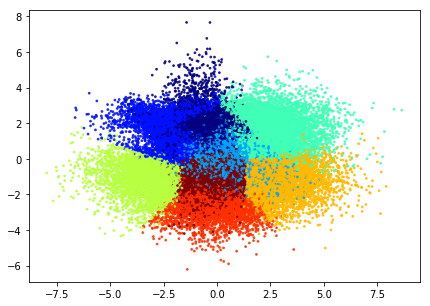

In [26]:
pca = PCA(n_components = 2)
data_2 = pca.fit_transform(data)
fig, ax = plt.subplots(1,1, figsize=(7,5))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
scat = ax.scatter(data_2.T[0],data_2.T[1],c=kmeans_labels,cmap=cmap, alpha=0.8, s=3)
plt.show()

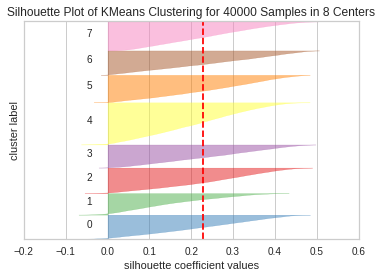

In [5]:
visualizer = SilhouetteVisualizer(KMeans(n_clusters=len(np.unique(target))*2))
visualizer.fit(data)
visualizer.poof()

# DBSCAN

Наступним алгоритмом кластеризації використаємо DBSCAN

In [43]:
dbscan = DBSCAN(eps=0.5, min_samples=7).fit(data)

In [44]:
metric1 = com(labels_true=target, labels_pred=dbscan.labels_)
metric2 = sil(X=data, labels=dbscan.labels_, sample_size=400)
print(f'Silhouette_score: {metric2}')
print(f'Completeness_score: {metric1}')

Silhouette_score: 0.06274414140821391
Completeness_score: 0.032795569669059194


Зобразимо отримані кластери

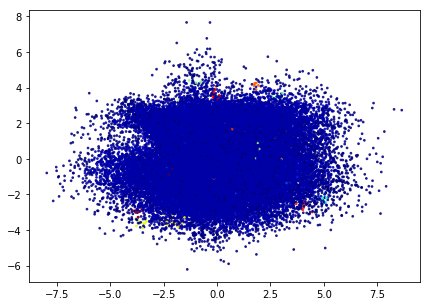

In [45]:
pca = PCA(n_components = 2)
data_2 = pca.fit_transform(data)
fig, ax = plt.subplots(1,1, figsize=(7,5))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
scat = ax.scatter(data_2.T[0],data_2.T[1],c=dbscan.labels_,cmap=cmap, alpha=0.8, s=3)
plt.show()

Помітно, що кластеризація цією моделлю не була успішною